In [75]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
from ta.momentum import RSIIndicator
from ta.trend import MACD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import mplcursors

In [62]:
TICKER = 'TSLA'

def prepare_data():
    stock_data = yf.download(TICKER, start='2014-01-01', end='2025-01-01')
    df = stock_data.copy()
    df.columns = df.columns.get_level_values(0)
    df = df.rename(columns={'Vol': 'Volume'})

    # Calculate a normalized price metric
    df['normalized'] = (df['Close'] - df['Low']) / ((df['High'] - df['Low']).replace(0, np.nan)).fillna(0.5)

    # Function to calculate regression slope
    def calculate_slope(series):
        return np.polyfit(np.arange(len(series)), series, 1)[0] if len(series) > 1 else np.nan

    windows = [3, 5, 10, 20]
    for w in windows:
        df[f'regression_{w}d'] = df['Close'].rolling(window=w, min_periods=2).apply(calculate_slope, raw=True)

    # Technical Indicators
    df['RSI'] = RSIIndicator(df['Close'], window=14).rsi()
    macd = MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['Volatility'] = df['Close'].pct_change().rolling(5).std()

    # Identify local extrema for target signals
    local_min = argrelextrema(df['Close'].values, np.less, order=5)[0]
    local_max = argrelextrema(df['Close'].values, np.greater, order=5)[0]

    # Create target column for training:
    #   0 -> Buy signal, 1 -> Sell signal, 2 -> Natural (default)
    df['target'] = 2  # assign natural as the default
    df.iloc[local_min, df.columns.get_loc('target')] = 0  # Buy signal
    df.iloc[local_max, df.columns.get_loc('target')] = 1  # Sell signal

    # Define features to be used in the model
    features = ['normalized', 'Volume', 'RSI', 'MACD', 'Volatility'] + [f'regression_{w}d' for w in windows]

    # For backtesting, drop rows with missing features.
    df_features = df.dropna(subset=features).copy()

    # For training, drop rows missing features (target is always present now)
    model_df = df.dropna(subset=features).copy()

    # Ensure data is sorted by date (important for time series)
    df_features.sort_index(inplace=True)
    model_df.sort_index(inplace=True)
    return df_features, model_df

try:
    df_features, model_df = prepare_data()
    print("Data preparation successful!")
    print("Sample training data:")
    print(model_df[['Close', 'RSI', 'MACD', 'regression_5d', 'target']].tail())
except Exception as e:
    print(f"Data error: {str(e)}")

# Split training data (from model_df) into train and test based on date.
train_df = model_df[model_df.index < '2023-01-01'].copy()
# For backtesting, use all available data after 2023 from df_features.
test_df  = df_features[df_features.index >= '2023-01-01'].copy()

print(f"\nTraining Data: {train_df.shape[0]} rows")
print(f"Backtesting Data: {test_df.shape[0]} rows")


[*********************100%***********************]  1 of 1 completed


Data preparation successful!
Sample training data:
Price            Close        RSI       MACD  regression_5d  target
Date                                                               
2024-12-24  462.279999  68.422829  34.480358       3.872998       2
2024-12-26  454.130005  65.645587  34.011526       7.713998       2
2024-12-27  431.660004  58.585163  31.464133       4.473001       2
2024-12-30  417.410004  54.576261  27.972995      -5.700000       2
2024-12-31  403.839996  50.997470  23.836484     -15.360001       2

Training Data: 2241 rows
Backtesting Data: 502 rows


In [63]:
def custom_predict(model, X, decision_threshold=0.3):
    """
    Use the predicted probabilities to apply threshold tuning.
    
    For each sample, if the probability of class 0 (buy) or class 1 (sell)
    exceeds the decision_threshold, assign the label with the highest probability among these.
    Otherwise, assign class 2 (natural).
    
    Note: This assumes that model.classes_ is sorted as [0, 1, 2].
    """
    proba = model.predict_proba(X)
    preds = []
    for p in proba:
        # p[0]: probability for class 0 (buy)
        # p[1]: probability for class 1 (sell)
        # p[2]: probability for class 2 (natural)
        if p[0] >= decision_threshold or p[1] >= decision_threshold:
            # If at least one of the buy/sell probabilities is high enough, choose the higher of the two.
            preds.append(0 if p[0] >= p[1] else 1)
        else:
            preds.append(2)
    return np.array(preds)

def train_model(model_df, decision_threshold=0.3):
    features = ['normalized', 'Volume', 'RSI', 'MACD', 'Volatility',
                'regression_3d', 'regression_5d', 'regression_10d', 'regression_20d']
    
    missing = [f for f in features if f not in model_df.columns]
    if missing:
        raise ValueError(f"Missing features: {missing}")
    
    X = model_df[features]
    y = model_df['target'].astype(int)
    
    # --- Cost-Sensitive Learning: Compute balanced class weights ---
    unique_classes = np.unique(y)
    balanced_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y)
    custom_class_weight = dict(zip(unique_classes, balanced_weights))
    # Further reduce the weight for class 2 (natural) since it's over-represented.
    if 2 in custom_class_weight:
        custom_class_weight[2] *= 0.5

    print("Custom class weights being used:", custom_class_weight)
    
    # --- Define base estimators with cost-sensitive parameters ---
    base_estimators = [
        ('rf', RandomForestClassifier(
                n_estimators=200,
                class_weight=custom_class_weight,
                max_depth=5,
                random_state=42)),
        ('svc', SVC(
                probability=True,
                class_weight=custom_class_weight,
                random_state=42)),
        ('lr', LogisticRegression(
                class_weight=custom_class_weight,
                max_iter=1000,
                random_state=42))
    ]
    
    # --- Define the final estimator for stacking ---
    final_estimator = LogisticRegression(
        class_weight=custom_class_weight,
        max_iter=1000,
        random_state=42)
    
    # --- Build the StackingClassifier ---
    stacking_clf = StackingClassifier(
        estimators=base_estimators,
        final_estimator=final_estimator,
        cv=5,            # internal CV for stacking (you can adjust this)
        n_jobs=-1,
        passthrough=False  # set to True if you want the meta-model to receive original features too.
    )
    
    # --- Time Series Cross-Validation with Threshold Tuning ---
    tscv = TimeSeriesSplit(n_splits=5)
    fold_metrics = []
    
    print("\nStarting 5-Fold Time Series Cross-Validation with Threshold Tuning:\n")
    for fold, (train_idx, valid_idx) in enumerate(tscv.split(X)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        # Fit the stacking classifier on the training fold.
        stacking_clf.fit(X_train, y_train)
        
        # Instead of default predict, use our custom threshold-based prediction.
        y_pred = custom_predict(stacking_clf, X_valid, decision_threshold=decision_threshold)
        
        # Gather metrics.
        report_dict = classification_report(y_valid, y_pred, output_dict=True, zero_division=0)
        accuracy = accuracy_score(y_valid, y_pred)
        confusion = confusion_matrix(y_valid, y_pred)
        
        fold_metrics.append({
            'fold': fold,
            'accuracy': accuracy,
            'report': report_dict,
            'confusion': confusion
        })
        
        # Print out metrics for the current fold.
        print(f"Fold {fold + 1} Metrics:")
        print(f"Accuracy: {accuracy:.3f}")
        for cls in ['0', '1', '2']:
            if cls in report_dict:
                precision = report_dict[cls]['precision']
                recall = report_dict[cls]['recall']
                f1 = report_dict[cls]['f1-score']
                support = report_dict[cls]['support']
                print(f"  Class {cls} -- Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, Support: {support}")
        print("Macro Avg --",
              f"Precision: {report_dict['macro avg']['precision']:.3f},",
              f"Recall: {report_dict['macro avg']['recall']:.3f},",
              f"F1-Score: {report_dict['macro avg']['f1-score']:.3f}")
        print("Weighted Avg --",
              f"Precision: {report_dict['weighted avg']['precision']:.3f},",
              f"Recall: {report_dict['weighted avg']['recall']:.3f},",
              f"F1-Score: {report_dict['weighted avg']['f1-score']:.3f}")
        print("Confusion Matrix:")
        print(confusion)
        print("-" * 50, "\n")
    
    # --- Train Final Model on the Entire Training Set ---
    final_model = StackingClassifier(
        estimators=base_estimators,
        final_estimator=final_estimator,
        cv=5,
        n_jobs=-1,
        passthrough=False
    )
    final_model.fit(X, y)
    
    # Note: You can also wrap the final_model's predict with custom_predict if you wish to use threshold tuning at test time.
    
    return final_model, model_df, features, fold_metrics 

# Train on the training set only.
# (Make sure 'train_df' has been prepared as per your earlier data preparation cell.)
model, _, features, fold_metrics = train_model(train_df, decision_threshold=0.3)


Custom class weights being used: {0: 5.976, 1: 5.574626865671642, 2: 0.1884460141271443}

Starting 5-Fold Time Series Cross-Validation with Threshold Tuning:

Fold 1 Metrics:
Accuracy: 0.097
  Class 0 -- Precision: 0.071, Recall: 1.000, F1-Score: 0.133, Support: 17.0
  Class 1 -- Precision: 0.141, Recall: 0.905, F1-Score: 0.244, Support: 21.0
  Class 2 -- Precision: 0.000, Recall: 0.000, F1-Score: 0.000, Support: 335.0
Macro Avg -- Precision: 0.071, Recall: 0.635, F1-Score: 0.126
Weighted Avg -- Precision: 0.011, Recall: 0.097, F1-Score: 0.020
Confusion Matrix:
[[ 17   0   0]
 [  2  19   0]
 [219 116   0]]
-------------------------------------------------- 

Fold 2 Metrics:
Accuracy: 0.177
  Class 0 -- Precision: 0.120, Recall: 1.000, F1-Score: 0.215, Support: 22.0
  Class 1 -- Precision: 0.151, Recall: 1.000, F1-Score: 0.263, Support: 26.0
  Class 2 -- Precision: 1.000, Recall: 0.055, F1-Score: 0.105, Support: 325.0
Macro Avg -- Precision: 0.424, Recall: 0.685, F1-Score: 0.194
Weighte

In [64]:
class Backtester:
    def __init__(self, initial_balance=3000):
        self.initial_balance = initial_balance
        self.reset()
        
    def reset(self):
        self.cash = self.initial_balance
        self.shares = 0
        self.trades = []
        self.portfolio = [self.initial_balance]
        self.peak = self.initial_balance
        self.drawdown = 0
        self.drawdown_history = [] 
        
    def run(self, data, model, features, threshold=0.4):
        self.reset()
        data = data.copy()
        
        data['pred_proba'] = model.predict_proba(data[features])[:, 1]
        data['signal'] = (data['pred_proba'] > threshold).astype(int)
        
        for idx, row in data.iterrows():
            current_value = self.cash + self.shares * row['Close']
            self.portfolio.append(current_value)
            
            self.peak = max(self.peak, current_value)
            current_drawdown = (self.peak - current_value)/self.peak
            self.drawdown = max(self.drawdown, current_drawdown)
            self.drawdown_history.append(current_drawdown)
            
            if self.shares == 0 and row['signal'] == 0:
                # Buy
                self.shares = self.cash / row['Close']
                self.cash = 0
                self.trades.append({'type': 'buy', 'date': idx, 'price': row['Close']})
                
            elif self.shares > 0 and row['signal'] == 1:
                # Sell
                self.cash = self.shares * row['Close']
                self.shares = 0
                self.trades.append({
                    'type': 'sell',
                    'date': idx,
                    'price': row['Close'],
                    'profit': self.cash - self.initial_balance
                })
        
        return self.trades, self.portfolio[1:]

In [76]:
plt.style.use('dark_background')

def plot_strategy_analysis(name, trades, portfolio, drawdowns, data, initial_balance):
    # Filter test data (example: from 2023-01-01 onward)
    test_data = data[data.index >= '2023-01-01']
    buy_dates = [t['date'] for t in trades if t['type'] == 'buy']
    sell_dates = [t['date'] for t in trades if t['type'] == 'sell']
    
    # Create a figure with an 8-row x 2-column grid.
    # Increase the height ratio for the candlestick chart by setting a higher value in the first row.
    fig = plt.figure(figsize=(18, 20))
    # Here, row 0 is for the candlestick chart. We set its ratio to 5 (instead of 3) to make it much larger.
    gs = gridspec.GridSpec(8, 2, height_ratios=[5, 2, 1, 1, 1, 1, 1, 1])
    
    # --- (1) Candlestick Chart with Trading Signals (Much Bigger) ---
    ax1 = plt.subplot(gs[0, :])
    
    # Prepare OHLC data (reset_index so that Date becomes a column)
    ohlc_data = test_data[['Open', 'High', 'Low', 'Close']].reset_index()
    # Convert dates to matplotlib's internal date format
    ohlc_data['Date'] = ohlc_data['Date'].map(mdates.date2num)
    
    # Plot candlesticks using mplfinance's original flavor
    candlestick_ohlc(
        ax1, 
        ohlc_data[['Date', 'Open', 'High', 'Low', 'Close']].values,
        width=0.6,
        colorup='#2ecc71',    # Green for up days
        colordown='#e74c3c',  # Red for down days
        alpha=0.8
    )
    
    # Add buy signals as shaded regions and markers
    for bd in buy_dates:
        ax1.axvspan(mdates.date2num(bd - pd.Timedelta(hours=12)), 
                    mdates.date2num(bd + pd.Timedelta(hours=12)), 
                    facecolor='#2ecc71', alpha=0.15)
    ax1.scatter([mdates.date2num(d) for d in buy_dates], 
                test_data.loc[buy_dates, 'Close'],
                marker='^', color='#27ae60', s=130, edgecolors='white',
                linewidth=1.5, label='Buy Signal', zorder=3)
    
    # Add sell signals as markers
    ax1.scatter([mdates.date2num(d) for d in sell_dates], 
                test_data.loc[sell_dates, 'Close'],
                marker='v', color='#c0392b', s=130, edgecolors='white',
                linewidth=1.5, label='Sell Signal', zorder=3)
    
    # Format the x-axis with dates
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    ax1.set_title(f'{name} - Candlestick Chart with Trading Signals', fontsize=16, pad=20)
    ax1.set_ylabel('Price (USD)', fontsize=14)
    ax1.legend(loc='upper left')
    ax1.grid(alpha=0.25)
    
    # Add interactive hover for candlestick chart
    mplcursors.cursor(ax1, hover=True)
    
    # --- (2) Price Line Chart with Trading Signals (Line in White) ---
    ax2 = plt.subplot(gs[1, :])
    ax2.plot(test_data.index, test_data['Close'], color='white', lw=1.5, label='Price')
    
    for bd in buy_dates:
        ax2.axvspan(bd - pd.Timedelta(hours=12), bd + pd.Timedelta(hours=12), 
                    facecolor='lime', alpha=0.2)
    ax2.scatter(buy_dates, test_data.loc[buy_dates, 'Close'], 
                marker='^', color='darkgreen', s=120, edgecolors='white', 
                linewidth=1, label='Buy', zorder=3)
    ax2.scatter(sell_dates, test_data.loc[sell_dates, 'Close'],
                marker='v', color='maroon', s=120, edgecolors='white', 
                linewidth=1, label='Sell', zorder=3)
    ax2.set_title(f'{name} - Price with Trading Signals (Line Chart)', fontsize=14)
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Add interactive hover for line chart
    mplcursors.cursor(ax2, hover=True)
    
    # --- (3) Win/Loss Trade Outcomes ---
    ax3 = plt.subplot(gs[2, :])
    win_dates = [t['date'] for t in trades if t['type'] == 'sell' and t.get('profit', 0) > 0]
    loss_dates = [t['date'] for t in trades if t['type'] == 'sell' and t.get('profit', 0) <= 0]
    
    ax3.plot(test_data.index, test_data['Close'], color='gray', alpha=0.4, label='Price')
    ax3.scatter(win_dates, test_data.loc[win_dates, 'Close'], 
                color='lime', s=50, label='Win')
    ax3.scatter(loss_dates, test_data.loc[loss_dates, 'Close'],
                color='red', s=50, label='Loss')
    ax3.set_title('Win/Loss Trade Outcomes', fontsize=12)
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    # --- (4) MACD Indicator ---
    ax4 = plt.subplot(gs[3, :])
    ax4.plot(test_data.index, test_data['MACD'], label='MACD', color='blue')
    ax4.plot(test_data.index, test_data['MACD_signal'], label='Signal', color='orange')
    ax4.axhline(0, color='grey', ls='--', alpha=0.5)
    ax4.set_title('MACD', fontsize=12)
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    # --- (5) RSI ---
    ax5 = plt.subplot(gs[4, :])
    ax5.plot(test_data.index, test_data['RSI'], color='purple')
    ax5.axhline(30, color='red', ls='--', alpha=0.7)
    ax5.axhline(70, color='red', ls='--', alpha=0.7)
    ax5.set_ylim(0, 100)
    ax5.set_title('RSI', fontsize=12)
    ax5.grid(alpha=0.3)
    
    # --- (6) Portfolio Value and Drawdown ---
    ax6 = plt.subplot(gs[5, 0])
    ax6.plot(portfolio, color='#27ae60', lw=1.5)
    ax6.set_title('Portfolio Value', fontsize=12)
    ax6.grid(alpha=0.3)
    
    ax7 = plt.subplot(gs[5, 1])
    ax7.plot([d * 100 for d in drawdowns], color='#c0392b', lw=1.2)
    ax7.set_title('Drawdown (%)', fontsize=12)
    ax7.grid(alpha=0.3)
    
    # --- (7) Win/Loss Pie Chart ---
    ax8 = plt.subplot(gs[6, 0])
    profits = [t.get('profit', 0) for t in trades if t['type'] == 'sell']
    win_rate = sum(p > 0 for p in profits) / len(profits) if profits else 0
    ax8.pie([win_rate, 1 - win_rate], labels=['Win', 'Loss'],
            colors=['#2ecc71', '#e74c3c'], autopct='%1.1f%%', startangle=90,
            wedgeprops={'linewidth': 1, 'edgecolor': 'white'})
    ax8.set_title('Win/Loss Ratio', fontsize=12)
    
    # --- (8) Performance Summary Text ---
    ax9 = plt.subplot(gs[6, 1])
    ax9.axis('off')  # Hide the axes for a text box
    final_balance = portfolio[-1]
    total_return = ((final_balance / initial_balance) - 1) * 100
    summary_text = (
        f"{name} Performance Summary:\n\n"
        f"Initial Balance: ${initial_balance:,.2f}\n"
        f"Final Balance:   ${final_balance:,.2f}\n"
        f"Total Return:    {total_return:.2f}%\n"
        f"Max Drawdown:    {max(drawdowns) * 100:.1f}%\n"
        f"Win Rate:        {win_rate:.1%}\n"
        f"Total Trades:    {len(trades)//2}"
    )
    ax9.text(0.5, 0.5, summary_text, horizontalalignment='center', 
             verticalalignment='center', fontsize=12)
    
    # Print the performance summary to the console as well
    print(summary_text)
    
    # Optional: Add interactive hover on the pie chart (if desired)
    mplcursors.cursor(ax8, hover=True)
    
    # Adjust spacing and display the figure
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

TSLA ML Strategy Performance Summary:

Initial Balance: $3,000.00
Final Balance:   $5,570.48
Total Return:    85.68%
Max Drawdown:    34.5%
Win Rate:        100.0%
Total Trades:    64


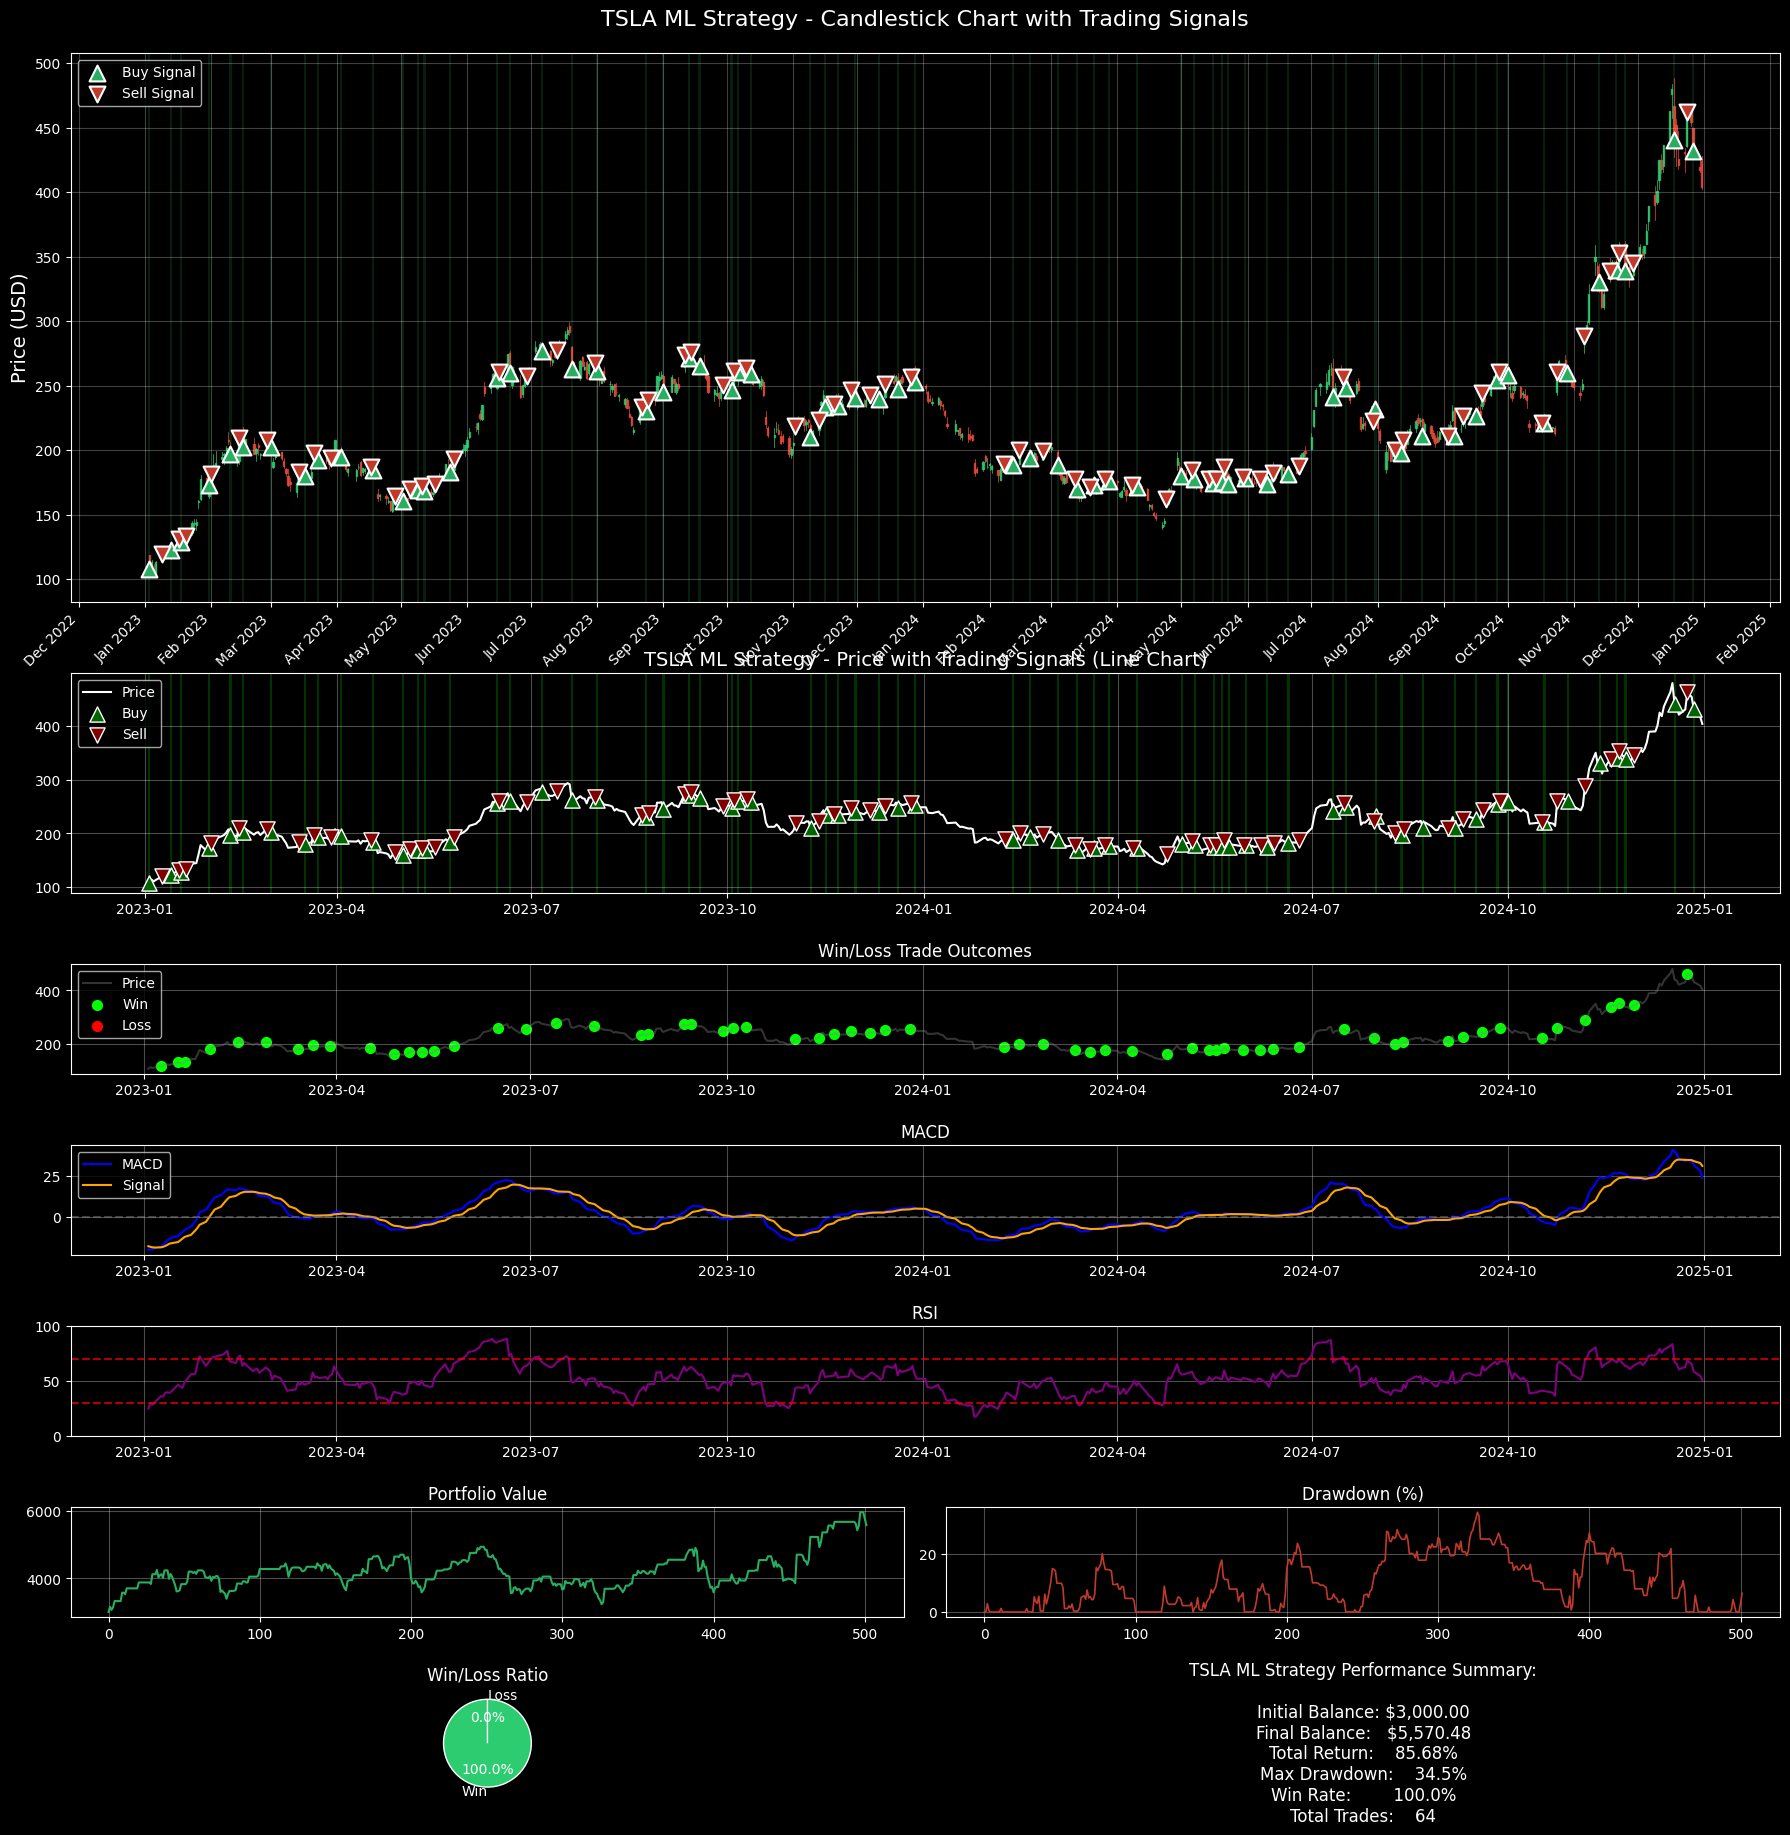

In [77]:
try:
    bt = Backtester(initial_balance=3000)
    trades, portfolio = bt.run(test_df, model, features)
    
    drawdown_series = pd.Series(bt.drawdown_history, index=test_df.index)
    
    plot_strategy_analysis(
        name=f"{TICKER} ML Strategy",
        trades=trades,
        portfolio=portfolio,
        drawdowns=drawdown_series.tolist(),
        data=df_features,  
        initial_balance=3000
    )
    
except Exception as e:
    print(f"\nExecution error: {str(e)}")